## CS310 Natural Language Processing
## Assignment 4. Long Short Term Memory (LSTM) Network for Named Entity Recognition (NER)

**Total points**: 50 + (10 bonus)

In this assignment, you will implement a Long Short Term Memory (LSTM) network for Named Entity Recognition (NER). 

Re-use the code in Lab 5.

### 0. Import Necessary Libraries

In [1]:
from pprint import pprint
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from utils import Indexer, read_ner_data_from_connl, get_batch
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import get_tag_indices_from_scores
from metrics import MetricsHandler

In [2]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/dev.txt'
TEST_PATH = 'data/test.txt'
EMBEDDINGS_PATH = 'data/glove.6B.100d.txt'
# Download from https://nlp.stanford.edu/data/glove.6B.zip
# It includes dimension 50, 100, 200, and 300.

In [3]:
train_words, train_tags = read_ner_data_from_connl(TRAIN_PATH)
dev_words, dev_tags = read_ner_data_from_connl(DEV_PATH)
test_words, test_tags = read_ner_data_from_connl(TEST_PATH)
train_words = [word.lower() for word in train_words]
dev_words = [word.lower() for word in dev_words]
test_words = [word.lower() for word in test_words]
print('train words size:', len(train_words))
print('dev words size:', len(dev_words))
print('test words size:', len(test_words))

train words size: 203621
dev words size: 51362
test words size: 46435


In [4]:
print(train_words[:10])
print(train_tags[:10])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', 'peter']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER']


In [5]:
pprint(list(zip(train_words[:10], train_tags[:10])))

[('eu', 'B-ORG'),
 ('rejects', 'O'),
 ('german', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('british', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O'),
 ('peter', 'B-PER')]


Build Vocab

In [6]:
indexer_train_words = Indexer(train_words)
indexer_train_tags = Indexer(train_tags)
indexer_dev_words = Indexer(dev_words)
indexer_dev_tags = Indexer(dev_tags)
indexer_test_words = Indexer(test_words)
indexer_test_tags = Indexer(test_tags)
# Test
print('index of word "the":', indexer_train_words.element_to_index('the'))
print('index of tag "O":', indexer_train_tags.element_to_index('O'))
print('word with index 0:', indexer_train_words.index_to_element(0))
print('word with index 100:', indexer_train_words.index_to_element(100))
print('tag with index 0:', indexer_train_tags.index_to_element(0))
print('tag with index 1:', indexer_train_tags.index_to_element(1))

index of word "the": 14
index of tag "O": 2
word with index 0: <UNKNOWN>
word with index 100: brains
tag with index 0: <UNKNOWN>
tag with index 1: B-ORG


In [7]:
indexer_words = Indexer(train_words + dev_words + test_words)
indexer_tags = Indexer(train_tags + dev_tags + test_tags)

# Test
print('sizes of indexers from all data:')
print(len(indexer_words), len(indexer_tags))

sizes of indexers from all data:
26870 10


Batching

In [8]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, words, tags, word_indexer, tag_indexer):
        """
        words: List[str]  — 每个元素是一个句子的词序列
        tags:  List[str]  — 每个元素是一个句子的标签序列
        word_indexer: 提供 index_of(word) 的方法
        tag_indexer:  提供 index_of(tag) 的方法
        """
        self.words = words
        self.tags = tags
        self.word_indexer = word_indexer
        self.tag_indexer = tag_indexer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        # print("idx: ",idx)
        word_ids = self.word_indexer.element_to_index(self.words[idx])
        tag_ids = self.tag_indexer.element_to_index(self.tags[idx])
        return torch.tensor(word_ids), torch.tensor(tag_ids)

In [9]:
# TRAIN
train_dataset = NERDataset(train_words, train_tags, indexer_words, indexer_tags)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# DEV
dev_dataset = NERDataset(dev_words, dev_tags, indexer_words, indexer_tags)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=32, shuffle=False)

# TEST
test_dataset = NERDataset(test_words, test_tags, indexer_words, indexer_tags)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
def load_glove_embeddings(glove_path, word_indexer, embedding_dim=100):
    vocab_size = len(word_indexer)
    embeddings = torch.randn(vocab_size, embedding_dim) * 0.1  # 初始化为随机值
    found = 0

    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            splits = line.strip().split()
            word = splits[0]
            vector = list(map(float, splits[1:]))
            if word in word_indexer.get_element_to_index_dict():
                idx = word_indexer.element_to_index(word)
                embeddings[idx] = torch.tensor(vector)
                found += 1

    print(f"Loaded {found} pretrained vectors from GloVe for vocab size {vocab_size}")
    return embeddings


In [11]:
pretrained_embeddings = load_glove_embeddings(EMBEDDINGS_PATH, indexer_words, embedding_dim=100)

embedding_layer = nn.Embedding(num_embeddings=len(indexer_words), embedding_dim=100)
embedding_layer.weight.data.copy_(pretrained_embeddings)


Loaded 22947 pretrained vectors from GloVe for vocab size 26870


tensor([[ 0.0201,  0.0135, -0.0670,  ..., -0.0078,  0.0029, -0.1063],
        [-0.3271,  0.0825,  1.2561,  ...,  0.3043,  0.9338,  0.1089],
        [ 0.0139,  0.7073,  0.8186,  ...,  0.1010,  0.7591,  0.3622],
        ...,
        [ 0.0568,  0.2734,  0.7063,  ..., -0.1658, -0.8528, -0.2504],
        [-0.1335, -0.1020, -0.2034,  ...,  0.0824, -1.2875,  0.2823],
        [ 0.0817, -0.0200,  0.0701,  ...,  0.0465,  0.0567, -0.0794]])

### 1. Build the Model

In [12]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=256, num_layers=2,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = not freeze_embeddings

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True)

        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)  # *2 because of bidirectional

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len)
        embeds = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embeds)  # (batch_size, seq_len, hidden_dim*2)
        tag_space = self.hidden2tag(lstm_out)  # (batch_size, seq_len, tagset_size)
        # print("tag_space:",tag_space)
        tag_scores = torch.log_softmax(tag_space, dim=1)  # log probabilities
        return tag_scores

### 2. Train and Evaluate

In [13]:
labels_str = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
labels_int = list(range(len(labels_str)))
# 训练前先创建 MetricsHandler
train_metrics = MetricsHandler(labels_int)
dev_metrics = MetricsHandler(labels_int)
test_metrics = MetricsHandler(labels_int)

def evaluate_model(model, data_loader, loss_func, eval_metrics, device):
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)

            predictions = get_tag_indices_from_scores(output.cpu().numpy())
            # print("predictions dtype:", type(predictions))
            targets_list = targets.cpu().numpy().tolist()
            eval_metrics.update(predictions, targets_list)
        eval_metrics.collect()
    metrics = eval_metrics.get_metrics()
    print(f"[Eval] F1-score: {metrics['F1-score'][-1]:.4f}")
    return metrics

def train_model(model, data_loader,dev_loader, optimizer, loss_func, train_metrics, num_epochs, device):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # train_metrics.collect()  # 每个 epoch 初始化统计表
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            # inputs, targets = batch.to # targets: (B, L)
            # print("batch: ",batch)
            output = model(inputs)  # output: (B, L, tag_size)

            output_flat = output.view(-1, output.size(-1))  # (B*L, tag_size)
            targets_flat = targets.view(-1)  # (B*L,)
            loss = loss_func(output_flat, targets_flat)

            loss.backward()
            optimizer.step()

            predictions = get_tag_indices_from_scores(output.detach().cpu().numpy())
            # prev_tag = model.tag_embed(predictions)
            targets_list = targets.detach().cpu().numpy().tolist()
            # for pred_seq, true_seq in zip(predictions, targets_list):
            train_metrics.update(predictions, targets_list)
            running_loss += loss.item() * inputs.size(0)
        train_metrics.collect()
        epoch_loss = running_loss / len(data_loader)
        losses.append(epoch_loss)
        metrics = train_metrics.get_metrics()
        print(f"[Epoch {epoch + 1}] Loss: {epoch_loss:.4f} | F1: {metrics['F1-score'][-1]:.4f}")
        evaluate_model(model, dev_loader, loss_fn, dev_metrics, device)
    return model, train_metrics, losses


In [14]:
def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(len(losses) + 1))
    plt.grid(True)
    plt.show()

In [15]:
def plot_f1_scores(f1_scores, title="F1-score per Epoch"):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='s', color='orange')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xticks(range(len(f1_scores) + 1))
    plt.grid(True)
    plt.show()

In [16]:
model = BiLSTMTagger(
    vocab_size=len(indexer_words),
    tagset_size=len(indexer_tags),
    embedding_dim=100,
    hidden_dim=256,
    num_layers=2,
    pretrained_embeddings=pretrained_embeddings,
    freeze_embeddings=False
)

In [17]:
epochs = 10
learning_rate = 1e-3
# 初始化
# loss_fn = nn.NLLLoss(ignore_index=-1)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
# 训练模型（5轮）
print("Training LSTM...")
model, train_metrics, losses = train_model(model, train_loader,dev_loader, optimizer, loss_fn, train_metrics, num_epochs=epochs, device=device)

Training LSTM...


100%|██████████| 6364/6364 [01:00<00:00, 105.71it/s]


[Epoch 1] Loss: 7.7375 | F1: 0.7407
[Eval] F1-score: 0.7690


100%|██████████| 6364/6364 [01:00<00:00, 105.10it/s]


[Epoch 2] Loss: 5.1610 | F1: 0.8224
[Eval] F1-score: 0.7820


100%|██████████| 6364/6364 [00:57<00:00, 110.16it/s]


[Epoch 3] Loss: 4.4524 | F1: 0.8473
[Eval] F1-score: 0.7847


100%|██████████| 6364/6364 [00:59<00:00, 107.83it/s]


[Epoch 4] Loss: 4.1459 | F1: 0.8596
[Eval] F1-score: 0.7894


100%|██████████| 6364/6364 [00:57<00:00, 111.13it/s]


[Epoch 5] Loss: 3.9613 | F1: 0.8644
[Eval] F1-score: 0.7691


100%|██████████| 6364/6364 [00:56<00:00, 112.01it/s]


[Epoch 6] Loss: 3.8820 | F1: 0.8649
[Eval] F1-score: 0.7619


100%|██████████| 6364/6364 [00:58<00:00, 109.68it/s]


[Epoch 7] Loss: 3.8137 | F1: 0.8680
[Eval] F1-score: 0.7764


100%|██████████| 6364/6364 [00:58<00:00, 109.31it/s]


[Epoch 8] Loss: 3.7820 | F1: 0.8675
[Eval] F1-score: 0.7875


100%|██████████| 6364/6364 [00:54<00:00, 117.60it/s]


[Epoch 9] Loss: 3.7455 | F1: 0.8689
[Eval] F1-score: 0.7943


100%|██████████| 6364/6364 [00:56<00:00, 111.77it/s]


[Epoch 10] Loss: 3.7187 | F1: 0.8712
[Eval] F1-score: 0.7856


Evaluating LSTM on dev set...
[Eval] F1-score: 0.7856
Evaluating LSTM on test set...
[Eval] F1-score: 0.7146


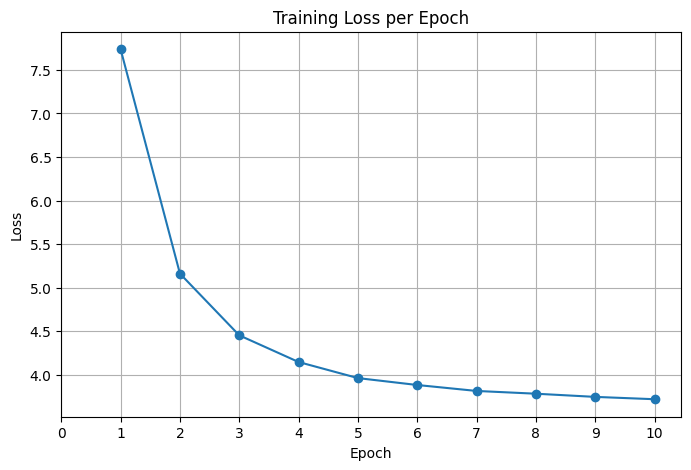

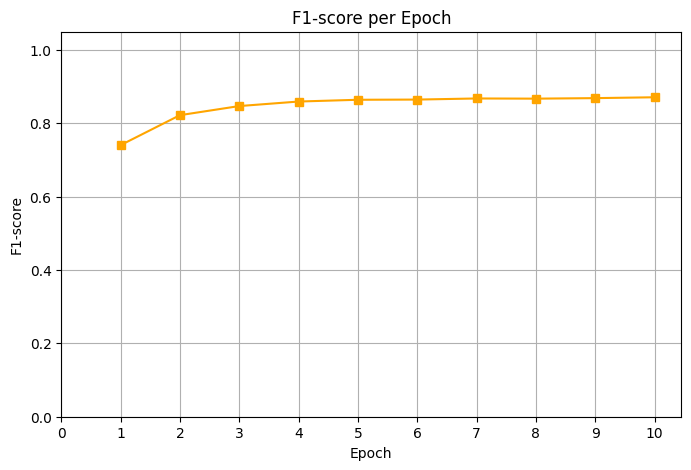

In [18]:
# 在 dev set 上评估
print("Evaluating LSTM on dev set...")
evaluate_model(model, dev_loader, loss_fn, dev_metrics, device)
# 最后在 test set 上评估
print("Evaluating LSTM on test set...")
evaluate_model(model, test_loader, loss_fn, test_metrics, device)
# 从 train_metrics 拿出 F1 分数列表
f1_scores = train_metrics.get_metrics()["F1-score"]
# 画图
plot_losses(losses) # training loss
plot_f1_scores(f1_scores) # f1 score of training